In [5]:
import cv2
import numpy as np


In [6]:
import imutils
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev


In [7]:
def get_perp_bisector(line):
    (x1, y1), (x2, y2) = line
    cx = (x1+x2)/2;
    cy = (y1+y2)/2;

    x1-=cx; y1-=cy;
    x2-=cx; y2-=cy;

    xtemp = x1; ytemp = y1;
    x1=-ytemp; y1=xtemp; 

    xtemp = x2; ytemp = y2;
    x2=-ytemp; y2=xtemp; 

    x1+=cx; y1+=cy;
    x2+=cx; y2+=cy;
    
    return ((int(x1), int(y1)), (int(x2), int(y2)))

In [8]:
def get_md_pt(line, contours, image):
    perp1 = get_perp_bisector(line)
    img_blk_ln = np.zeros(image.shape).astype(image.dtype)
    cv2.line(img_blk_ln, perp1[0], perp1[1], (255,255,255), thickness=1, lineType=8, shift=0)
    img_blk_cnt = np.zeros(image.shape).astype(image.dtype)
    cv2.drawContours(img_blk_cnt, contours, 0, (255,255, 255), 1)
    img_blk = np.zeros(image.shape).astype(image.dtype)
    cv2.bitwise_and(img_blk_cnt, img_blk_ln, img_blk)
#     cv2.line(image, line[0], line[1], (255, 0, 0), thickness=1, lineType=8, shift=0)
    pixelpoints = np.transpose(np.nonzero(img_blk))
#     plt.imshow(img_blk)
    return (pixelpoints[0][0], pixelpoints[0][1])
    

In [9]:
def smooth_contours(contours):
    smoothened = []
    for contour in contours:
        x,y = contour.T
        # Convert from numpy arrays to normal arrays
        x = x.tolist()[0]
        y = y.tolist()[0]
        # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
        tck, u = splprep([x,y], u=None, s=1.0, per=1)
        # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
        u_new = np.linspace(u.min(), u.max(), 25)
        # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
        x_new, y_new = splev(u_new, tck, der=0)
        # Convert it back to numpy format for opencv to be able to display it
        res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
        smoothened.append(np.asarray(res_array, dtype=np.int32))
    return smoothened

In [10]:
def warp_image(image, contours):
    rect = cv2.minAreaRect(contours[0])

    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    width = int(rect[1][0])
    height = int(rect[1][1])
    box = np.int0(box)

    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    angle = rect[2]
    if angle < -45:
        angle += 90

    center = ((x1+x2)/2,(y1+y2)/2)
    # Size of the upright rectangle bounding the rotated rectangle
    size = (x2-x1, y2-y1)
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    # Cropped upright rectangle
    cropped = cv2.getRectSubPix(image, size, center)
    cropped = cv2.warpAffine(cropped, M, size)
    croppedW = H if H > W else W
    croppedH = H if H < W else W
    # Final cropped & rotated rectangle
    return cv2.getRectSubPix(cropped, (int(croppedW),int(croppedH)), (size[0]/2, size[1]/2))

In [20]:
def find_pts(path):
    image_o = cv2.imread(path)
    gray = cv2.cvtColor(image_o, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    # plt.imshow(thresh, cmap="gray")
    old_contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    old_contours = imutils.grab_contours(old_contours)
    # smooth contours 
    contours = smooth_contours(old_contours)

    
    image = np.zeros(image_o.shape).astype(image_o.dtype)
    cv2.fillPoly(image, contours, [255,255,255])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Extract corners
    corners = cv2.goodFeaturesToTrack(gray, 4, 0.01, 20)
    corners = np.int0(corners)
    true_corners = []
    # get corners closest to contour
    for pt in corners:
        true_corners.append(min([(x, np.linalg.norm(x-pt)) for x in contours[0]], key = lambda t: t[1])[0].tolist()[0])
    # draw circle around points
    for pt in true_corners:
        (x, y) = pt
        cv2.circle(image, (x,y), 1, (255,0,0), thickness=1, lineType=8, shift=0)
    # draw lines for the corner pts
    sorted_pts = sorted(true_corners, key=lambda x: x[1])
    line1 = (tuple(sorted_pts[0]), tuple(sorted_pts[1]))
    line2 = (tuple(sorted_pts[2]), tuple(sorted_pts[3]))
#     cv2.line(image, line1[0], line2[0], (255,0,0), thickness=1, lineType=8, shift=0)
#     cv2.line(image, line1[1], line2[1], (255,0,0), thickness=1, lineType=8, shift=0)
    hms_y, hms_x = get_md_pt(line1, contours, image)
    hmi_y, hmi_x = get_md_pt(line2, contours, image)
    cv2.line(image, (hms_x, hms_y), (hmi_x, hmi_y), (255,0,0), thickness=1, lineType=8, shift=0)
    
#     cv2.circle(image, (hms_x, hms_y), 1, (0,255,0), thickness=1, lineType=8, shift=0)
#     cv2.circle(image, (hmi_x, hmi_y ), 1, (0,255,0), thickness=1, lineType=8, shift=0)
    
    # warp image
    
    
    
    t = cv2.imread('images/{}'.format(path.split('/')[1].split('_L_')[0] + '_L.png'))
    cv2.bitwise_and(t, image_o, image_o)
    croppedRotated = warp_image(image_o, old_contours)
    plt.imshow(croppedRotated)
    cv2.imwrite('keypts/{}'.format(path.split('/')[1]), croppedRotated)


(512, 512, 3) (512, 512, 3)
list index out of range
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][54]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][83]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][88]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][41]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][104]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][65]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][85]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(320, 320, 3) (320, 320, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][45]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][33]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][25]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][108]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][56]=x[0][0]
  (i, m, i)))


list index out of range
(256, 256, 3) (256, 256, 3)
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
list index out of range
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][49]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][72]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][68]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][53]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][34]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][63]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][86]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
list index out of range
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][71]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][38]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][55]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][29]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][69]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
list index out of range
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][79]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][70]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][51]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][93]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][50]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][90]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][47]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][89]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][97]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][97]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][39]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][62]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][91]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][103]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(256, 256, 3) (256, 256, 3)
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][42]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][73]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][82]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][106]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][5]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][5]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][109]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
list index out of range


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][40]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][23]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][67]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][37]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
list index out of range
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
list index out of range
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
list index out of range
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][68]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][115]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][57]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][121]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][87]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][99]=x[0][0]
  (i, m, i)))


index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
(320, 320, 3) (320, 320, 3)
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][102]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][76]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][84]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][105]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][92]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][59]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
(320, 320, 3) (320, 320, 3)
index 0 is out of bounds for axis 0 with size 0
(512, 512, 3) (512, 512, 3)
index 0 is out of bounds for axis 0 with size 0


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][136]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][125]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][32]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][96]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][78]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][30]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][60]=x[0][0]
  (i, m, i)))


list index out of range
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(320, 320, 3) (320, 320, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][52]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][117]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][46]=x[0][0]
  (i, m, i)))


(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][24]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][44]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][100]=x[0][0]
  (i, m, i)))


(320, 320, 3) (320, 320, 3)
list index out of range
list index out of range
index 0 is out of bounds for axis 0 with size 0


KeyboardInterrupt: 

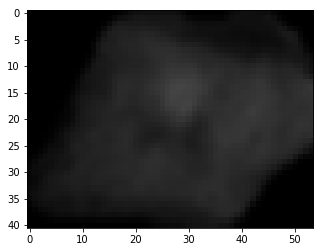

In [22]:
import os
for idx, x in enumerate(os.listdir('generated_masks')):
    try:
        find_pts('generated_masks/{}'.format(x))
    except Exception as e:
        print(e)

In [23]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data

In [63]:
patches = []
xs = []
ys = []
for idx, img in enumerate(os.listdir('keypts')):
    if idx < 1000:
        try:
            i = cv2.imread('keypts/{}'.format(img))
            i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
            glcm = greycomatrix(i, [5], [0], 256, symmetric=True, normed=True)
            xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
            ys.append(greycoprops(glcm, 'contrast')[0, 0])
        except Exception as e:
            print(e)

OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'



104


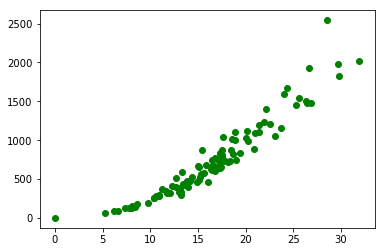

In [64]:
# create the figure
print(len(xs))
plt.plot(xs, ys, 'go')